# Root dir

In [8]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
ROOT = 'mri'
DATA_MAT = ROOT + '/data'
DATA_PNG = ROOT + '/dataset-seg-png'

# Download & Unzip data

In [12]:
import zipfile
import os
from tqdm import tqdm
import urllib.request

def download_with_progress(url, filename):
    """Download file with progress bar showing speed"""
    with urllib.request.urlopen(url) as response:
        total_size = int(response.headers.get('Content-Length', 0))

        with tqdm(total=total_size, unit='B', unit_scale=True, unit_divisor=1024,
                  desc=f"Downloading {filename}") as pbar:
            with open(filename, 'wb') as f:
                while True:
                    chunk = response.read(8192)  # 8KB chunks
                    if not chunk:
                        break
                    f.write(chunk)
                    pbar.update(len(chunk))

if not os.path.isfile('brainTumorDataPublic_1766.zip'):
    url = 'https://figshare.com/ndownloader/articles/1512427/versions/8'
    print(f'Downloading data from {url}...')
    download_with_progress(url, 'brainTumorDataPublic_1766.zip')
    print('Download complete.')

print('Unzipping data...')
with zipfile.ZipFile('brainTumorDataPublic_1766.zip', 'r') as zip_ref:
    zip_ref.extractall(DATA_MAT)

zip_files = [
    f'{DATA_MAT}/brainTumorDataPublic_1-766.zip',
    f'{DATA_MAT}/brainTumorDataPublic_767-1532.zip',
    f'{DATA_MAT}/brainTumorDataPublic_1533-2298.zip',
    f'{DATA_MAT}/brainTumorDataPublic_2299-3064.zip'
]

for file in zip_files:
    folder_name = os.path.splitext(os.path.basename(file))[0]
    extract_path = os.path.join(DATA_MAT, folder_name)
    os.makedirs(extract_path, exist_ok=True)

    with zipfile.ZipFile(file, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    os.remove(file)

print('Data unzipped successfully.')

Download complete.
Unzipping data...
Data unzipped successfully.


# Create data - mask

In [13]:
import os
import h5py
import numpy as np
from tqdm import tqdm
from PIL import Image

def process_mat_to_png_mask(root_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    for subset in tqdm(sorted(os.listdir(root_dir)), desc="Processing subsets"):
        subset_path = os.path.join(root_dir, subset)
        if not os.path.isdir(subset_path):
            continue

        mat_files = [f for f in sorted(os.listdir(subset_path)) if f.endswith('.mat')]

        for fname in tqdm(mat_files, desc=f"{subset}", leave=False):
            mat_path = os.path.join(subset_path, fname)
            with h5py.File(mat_path, 'r') as f:
                cj = f['cjdata']
                img = np.array(cj['image']).T.astype(np.float64)
                img = ((img - img.min()) * 255 / (img.max() - img.min())).astype(np.uint8)
                h, w = img.shape

                lb_id = int(np.array(cj['label']).squeeze())
                lb_map = {'1': 'meningioma', '2': 'glioma', '3': 'pituitary'}
                label = lb_map[str(lb_id)]

                mask = np.array(cj['tumorMask']).T * 255

                label_dir = os.path.join(output_dir, label)
                os.makedirs(label_dir, exist_ok=True)

                base = os.path.splitext(fname)[0]
                img_out_path = os.path.join(label_dir, f'{base}.png')
                mask_out_path = os.path.join(label_dir, f'{base}_mask.png')

                Image.fromarray(img).save(img_out_path)
                Image.fromarray(mask).save(mask_out_path)

    print('Done!!!')

In [14]:
process_mat_to_png_mask(DATA_MAT, DATA_PNG)

Processing subsets: 100%|██████████| 6/6 [03:56<00:00, 39.35s/it]

Done!!!


# Read data

In [15]:
import os
import matplotlib.pyplot as plt
import cv2

In [16]:
folders = [f for f in os.listdir(DATA_PNG) if os.path.isdir(os.path.join(DATA_PNG, f))]
folders

['meningioma', 'glioma', 'pituitary']

In [20]:
def load_data(path_image):
    image = cv2.imread(path_image)
    mask = cv2.imread(path_image.replace('.png', '_mask.png'))
    return image, mask

path_image = ROOT + '/dataset-seg-png/glioma/730.png'
image, mask = load_data(path_image)

In [21]:
def show(image, mask):
    # show image, mask, and mask overlay in image
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].set_title('Image')
    axs[0].imshow(image, cmap='gray')
    axs[1].set_title('Mask')
    axs[1].imshow(mask)
    axs[2].set_title('Mask Overlay')
    axs[2].imshow(image)
    axs[2].imshow(mask, alpha=0.5)
    plt.show()

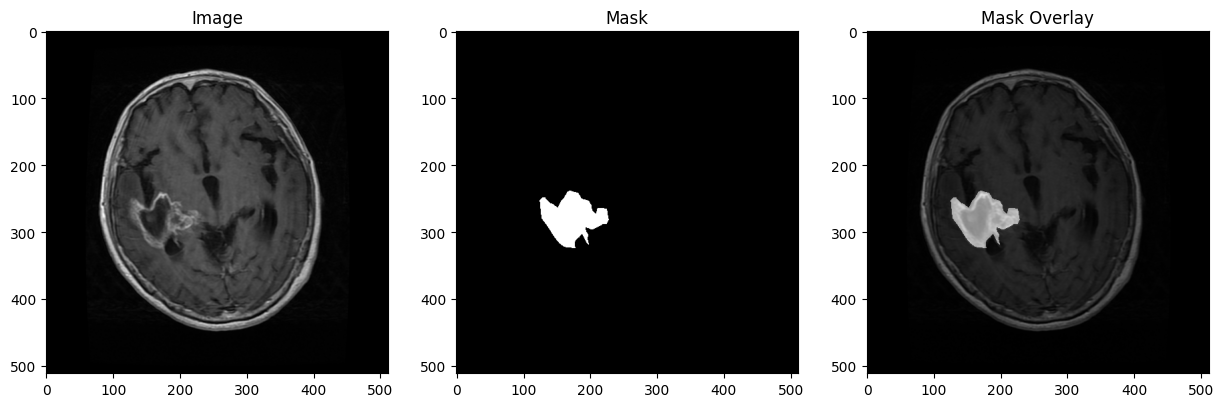

In [22]:
show(image, mask)